#### Install Dependencies and Libraries

In [34]:
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:4 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2905 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3336 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1527 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2306 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1065 kB]
Fetched 11.4 MB in 29s (391 kB/s)                                              
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is alre

In [35]:
!pip install opencv-python

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [36]:
import numpy as np
import pickle
from os import listdir
import os
import tensorflow
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#### Define Basic Variable which include Number of Epochs, Image size, etc

In [38]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'Dataset/images'
width=256
height=256
depth=3

#### Function to convert image to a numpy array

In [39]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

#### Load all the images as well as thier labels

In [40]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for fish_species_folder in root_dir:
            fish_species_list = os.listdir(f'{directory_root}/{fish_species_folder}')
            for image in fish_species_list:
                image_directory = f"{directory_root}/{fish_species_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(fish_species_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [41]:
image_size = len(image_list)
image_size

8436

#### Use LabelBinarizer to get all the differnet label realted to fish species

In [42]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform_Fina_1.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [43]:
print(label_binarizer.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [44]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [45]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [46]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

#### Define the model as Sequential and add different layers

In [47]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 85, 85, 64)       

In [49]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


#### Train the Model for 50 epoch and print the test loss, test accuracy, validation loss, validation accuracy

In [50]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/50
210/210 [==============================] - 64s 305ms/step - loss: 0.4693 - acc: 0.8348 - val_loss: 0.5010 - val_acc: 0.8101
Epoch 2/50
210/210 [==============================] - 64s 304ms/step - loss: 0.3389 - acc: 0.8705 - val_loss: 0.4767 - val_acc: 0.8359
Epoch 3/50
210/210 [==============================] - 63s 302ms/step - loss: 0.2776 - acc: 0.8912 - val_loss: 0.4262 - val_acc: 0.8373
Epoch 4/50
210/210 [==============================] - 64s 303ms/step - loss: 0.2098 - acc: 0.9170 - val_loss: 0.5851 - val_acc: 0.8664
Epoch 5/50
210/210 [==============================] - 64s 303ms/step - loss: 0.1548 - acc: 0.9393 - val_loss: 0.4081 - val_acc: 0.8798
Epoch 6/50
210/210 [==============================] - 63s 301ms/step - loss: 0.1270 - acc: 0.9497 - val_loss: 0.1550 - val_acc: 0.9392
Epoch 7/50
210/210 [==============================] - 63s 302ms/step - loss: 0.1022 - acc: 0.9595 - val_loss: 0.1453 - val_acc: 0.9442
Epoch 8/50
210/210 [==============================] - 6

#### Plot the Training and Validation Accuracy and loss and print the accuracy

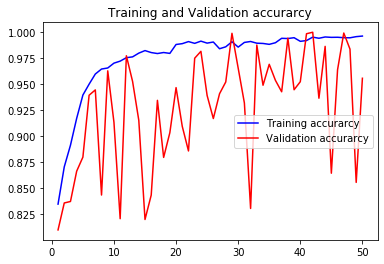

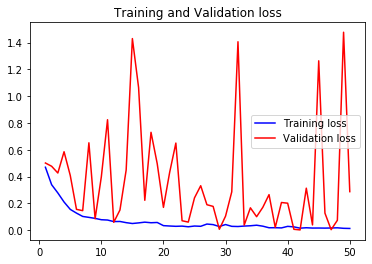

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [70]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy:", {scores[1]*100})

[INFO] Calculating model accuracy
1688/1688 [==============================] - 2s 1ms/sample - loss: 0.2866 - acc: 0.9554
Test Accuracy: {95.53993344306946}


#### Save the Model

In [72]:
print("[INFO] Saving model...")
model.save('cnn_model_1.h5')

[INFO] Saving model...
